In [168]:
import logging
import os.path

import numpy as np
from poap.controller import BasicWorkerThread, ThreadController

from pySOT.auxiliary_problems import candidate_uniform
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.experimental_design import LatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import SRBFStrategy,SOPStrategy,DYCORSStrategy
from pySOT.optimization_problems import Rosenbrock
from pySOT.utils import unit_rescale
from pySOT.strategy import DYCORSStrategy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import scipy.spatial as scpspatial
import scipy
from scipy.integrate import quad
import random

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [192]:
# unsure of how exactly to deal with the different cases
# for now I am just taking negative log transform of cases described
# ask about the way I've done the inequalities
# can implement c to be the running minimum also just by modifying properties in this class.
class Lm_rosenbrock(Rosenbrock):
    """Rosenbrock function

    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """

    def __init__(self, dim=10,ep = 1):
        self.ep = ep
        self.dim = dim
        #self.c = self.eval(np.random.random(size = self.dim))
        self.c = 0.5
        self.H_ys = []
        self.beta = 1/ep
        self.min = 0
        self.minimum = np.ones(dim)
        self.lb = -2.048 * np.ones(dim)
        self.ub = 2.048 * np.ones(dim)
        self.int_var = np.array([])
        self.cont_var = np.arange(0, dim)
        self.info = str(dim) + "-dimensional Rosenbrock function \n" + "Global optimum: f(1,1,...,1) = 0"

        # linear f
    def eval1(self, x):
        """Evaluate the modified Rosenbrock function  at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.log((H_y - self.c + self.ep)/self.ep)
        else:
            return (
                scipy.integrate.quad(lambda u: 1/(u - self.c + self.ep), a = self.min, b = H_y)[0]
            )
    
    # quadratic f
    def eval2(self, x):
        """Evaluate the modified Rosenbrock function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.sqrt(self.beta)*np.arctan(np.sqrt(self.beta)*(H_y - self.c))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**2 + self.ep), a = self.min, b = H_y)[0]
            )
    
    # square root f
    def eval3(self, x):
        """Evaluate the modified Rosenbrock function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return (self.beta*(self.c - self.min) + 2*np.sqrt(H_y - self.c)
                    - 2*self.ep*np.log((np.sqrt(H_y - self.c) + self.ep)/self.ep))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**(1/2) + self.ep), a = self.min, b = H_y)[0]
            )


In [33]:
r = Lm_rosenbrock()

In [15]:
def plotter():
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    num_threads = 4
    max_evals = 500
    num_runs = 5
    lm_rosenbrock = Lm_rosenbrock(dim=10)
    rbf = RBFInterpolant(dim=lm_rosenbrock.dim, lb=lm_rosenbrock.lb, ub=lm_rosenbrock.ub, kernel=CubicKernel(), tail=LinearTail(lm_rosenbrock.dim))
    slhd = SymmetricLatinHypercube(dim=lm_rosenbrock.dim, num_pts=2 * (lm_rosenbrock.dim + 1))

    results_async1 = np.zeros((max_evals, num_runs))
    for i in range(num_runs):
        # can change landscape by changing eval1 to eval2 or eval3 based on preferance
        controller1 = SerialController(objective=lm_rosenbrock.eval1)
        # can just change this to DYCORS for the more new strategy.
        controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
        result = controller1.run()
        results_async1[:, i] = np.array(
            [H_y for H_y in lm_rosenbrock.H_ys[i * max_evals:] if H_y is not None])
        
    results_async2 = np.zeros((max_evals, num_runs))
    for i in range(num_runs):
        controller2 = SerialController(objective=lm_rosenbrock.eval)
        controller2.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
        result = controller2.run()
        results_async2[:, i] = np.array(
            [o.value for o in controller2.fevals if o.value is not None])

    plt.figure(figsize=(15, 8))
    for results in [results_async1, results_async2]:
        fvals = np.minimum.accumulate(results) 
        print('hi')
        print(np.arange(max_evals)+1)
        print('bye')
        print(np.minimum.accumulate(results) )
        plt.errorbar(np.arange(max_evals)+1, y=np.mean(fvals, axis=1), 
                     yerr=np.std(fvals, axis=1)/np.sqrt(float(num_runs)))

#     plt.plot(np.arange(0, fvals.shape[0]), np.minimum.accumulate(fvals), lw=2)
    plt.ylabel("Best value found so far", fontsize=16)
    plt.xlabel("Evaluations", fontsize=16)
    plt.legend(("modified landscape", "original"), fontsize=16)
    plt.title('using linear f',fontsize = 18)
    plt.show()



#example_simple(12)
#random.seed(0)
#np.random.seed(0)
#plotter()

In [99]:
def ex_helper(times):
    max_evals = 500
    l2 = np.zeros((max_evals,times))
    for i in range(times):
        np.random.seed(i)
        random.seed(i)
        lm_rosenbrock = Rosenbrock(dim=10)
        rbf = RBFInterpolant(dim=lm_rosenbrock.dim, lb=lm_rosenbrock.lb, ub=lm_rosenbrock.ub, kernel=CubicKernel(), tail=LinearTail(lm_rosenbrock.dim))
        slhd = SymmetricLatinHypercube(dim=lm_rosenbrock.dim, num_pts=2 * (lm_rosenbrock.dim + 1))
        controller1 = SerialController(objective=lm_rosenbrock.eval)
        controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )

        # Run the optimization strategy
        result1 = controller1.run()
        l2[:,i] = np.array(
                [o.value for o in controller1.fevals if o.value is not None])
    return l2

In [100]:
l2 = ex_helper(30)

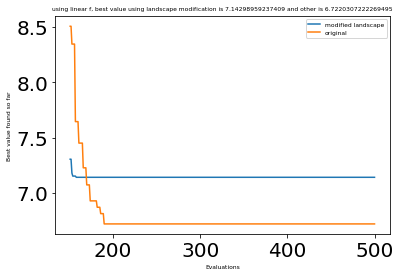

7.14298959237409 6.7220307222269495
10.052810999999565


In [193]:
%matplotlib inline
path = '/Users/venkatkrishnakarumanchi/Desktop/surrogate optimization research/pySOT-master/rosenbrock_results/results for square root rosenbrock/0.5_c'
# when I do it serially and also not asynchronously I am able to make it deterministic
# SOP is extremely,extremely slow, DYCORS is a bit slower than SBRF and both are similarly accurate based on tests
# however the paper says DYCORS is used for high dimensional problems but here I am doing only 10D problems

import time
start = time.process_time()
  
def example_simple(state,path,i,l2):
    np.random.seed(state)
    random.seed(state)
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    max_evals = 500
    
    lm_rosenbrock = Lm_rosenbrock(dim=10)
    rbf = RBFInterpolant(dim=lm_rosenbrock.dim, lb=lm_rosenbrock.lb, ub=lm_rosenbrock.ub, kernel=CubicKernel(), tail=LinearTail(lm_rosenbrock.dim))
    slhd = SymmetricLatinHypercube(dim=lm_rosenbrock.dim, num_pts=2 * (lm_rosenbrock.dim + 1))

    # Create a strategy and a controller
    # can change landscape by changing eval1 to eval2 or eval3 based on preferance
    controller = SerialController(objective=lm_rosenbrock.eval3)
    controller.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
    # Run the optimization strategy
    result = controller.run()
    l1 = lm_rosenbrock.H_ys

    fvals1 = np.minimum.accumulate(l1)
    fvals2 = np.minimum.accumulate(l2[:,i])
    for results in [fvals1[150:500],fvals2[150:500]]:
        plt.errorbar(np.arange(start = 150, stop = 500)+1, y=results)

    plt.ylabel("Best value found so far", fontsize=6)
    plt.xlabel("Evaluations", fontsize=6)
    plt.legend(("modified landscape", "original"), fontsize=6)
    plt.title('using linear f, best value using landscape modification is {0} and other is {1}'.
              format(lm_rosenbrock.eval(result.params[0]),min(l2[:,i])),
              fontsize = 6)
    #plt.figure(facecolor=(1, 1, 1))
    plt.savefig(path + '/graph_iter_{0}.jpg'.format(i), dpi = 200)
    plt.show()

    print(lm_rosenbrock.eval(result.params[0]),min(l2[:,i]))
    return lm_rosenbrock.eval(result.params[0]),min(l2[:,i])
    


example_simple(1,path,0,l2)
print(time.process_time() - start)

In [194]:

def rmse(x,x1):
    return np.sqrt(np.mean((x - x1)**2))

def checker(times,path,l2):
    lm = 0
    lm_list = []
    no_lm = 0
    no_lm_list = []
    for i in range(times):
        res = example_simple(i,path,i,l2)
        lm_list.append(res[0])
        no_lm_list.append(res[1])
        if res[0] < res[1]:
            lm += 1
        else:
            no_lm += 1
    print('rosenbrock, square root landscape modification, 0.5 c')
    print('landscape modified was better {0} times and was worse {1} times'.format(lm,no_lm))
    print('mean of landscape modified is {}'.format(np.mean(lm_list)))
    print('mean of non landscape modified is {}'.format(np.mean(no_lm_list)))
    print('median of landscape modified is {}'.format(np.median(lm_list)))
    print('median of non landscape modified is {}'.format(np.median(no_lm_list)))
    print('best result of landscape modified is {}'.format(np.min(lm_list)))
    print('best of non landscape modified is {}'.format(np.min(no_lm_list)))
    print('worst result of landscape modified is {}'.format(np.max(lm_list)))
    print('worst of non landscape modified is {}'.format(np.max(no_lm_list)))
    return lm_list,no_lm_list
    

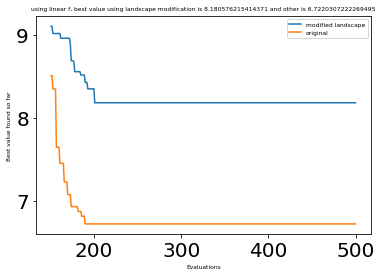

8.180576215414371 6.7220307222269495


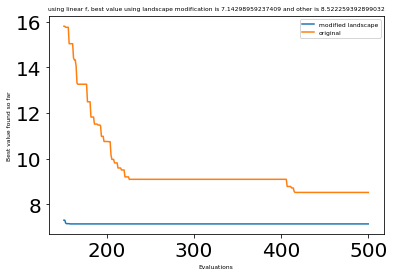

7.14298959237409 8.522259392899032


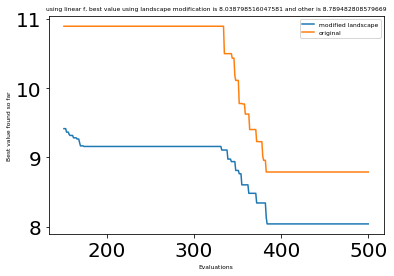

8.038798516047581 8.789482808579669


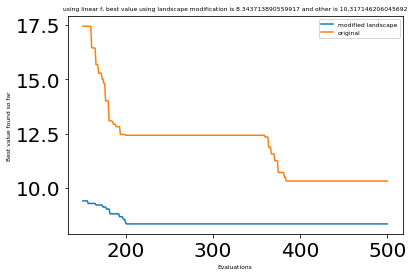

8.343713890559917 10.317146206045692


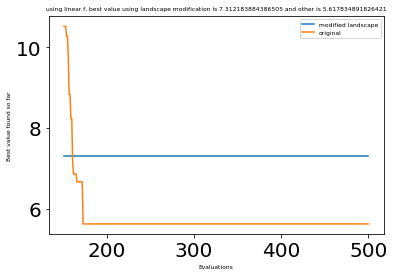

7.312183884386505 5.617834891826421


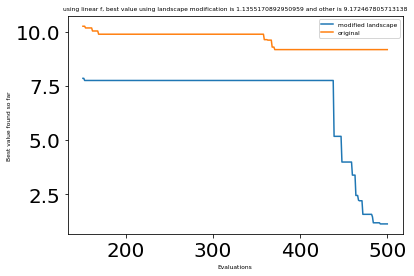

1.1355170892950959 9.172467805713138


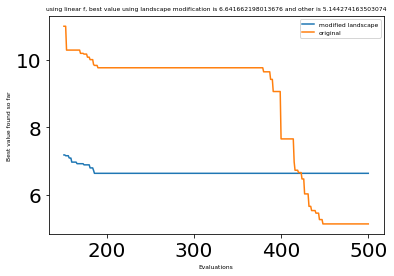

6.641662198013676 5.144274163503074


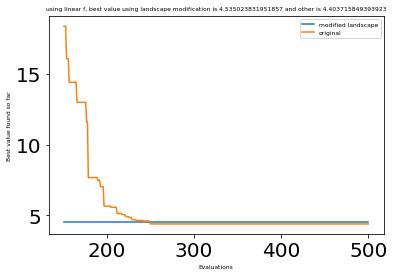

4.535023831951857 4.403715849393923


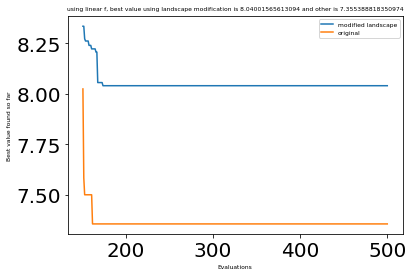

8.04001565613094 7.355388818350974


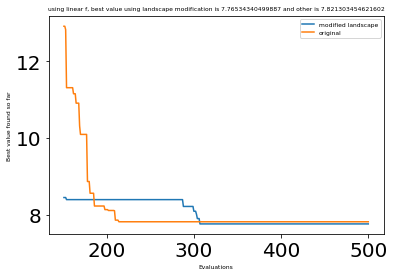

7.76534340499887 7.821303454621602


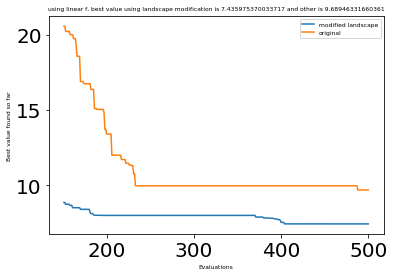

7.435975370033717 9.68946331660361


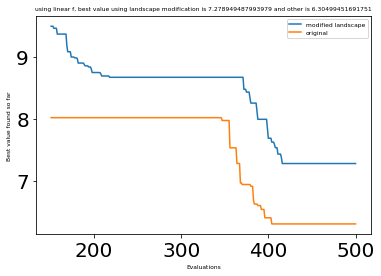

7.278949487993979 6.30499451691751


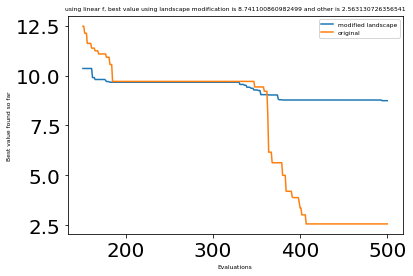

8.741100860982499 2.563130726356541


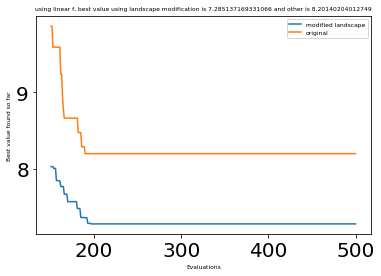

7.285137169331066 8.20140204012749


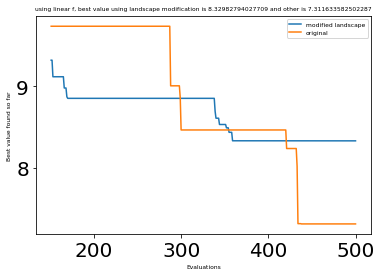

8.32982794027709 7.311633582502287


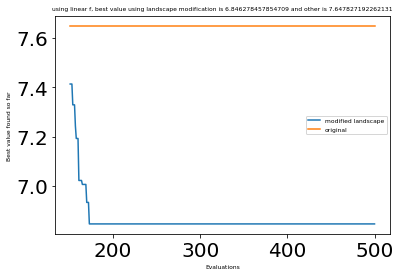

6.846278457854709 7.647827192262131


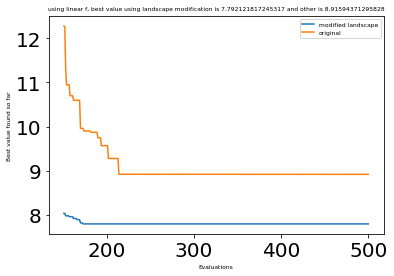

7.792121817245317 8.91594371295828


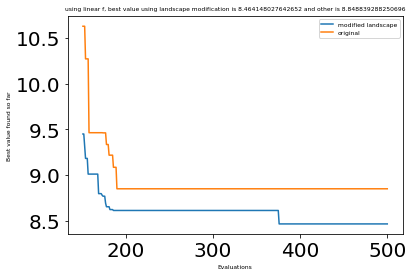

8.464148027642652 8.848839288250696


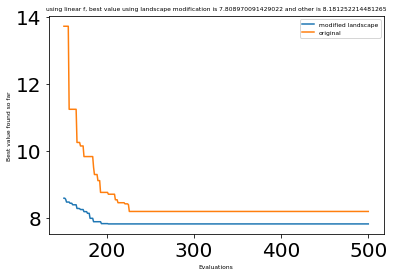

7.808970091429022 8.181252214481265


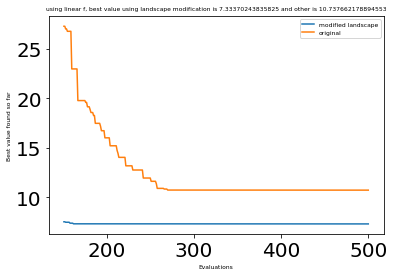

7.33370243835825 10.737662178894553


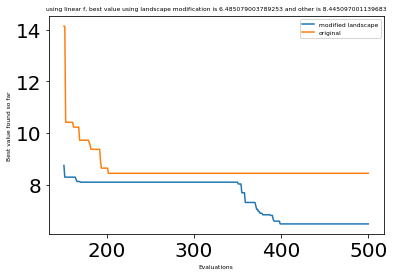

6.485079003789253 8.445097001139683


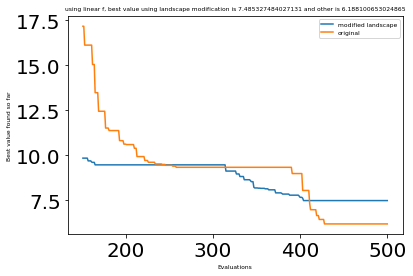

7.485327484027131 6.188100653024865


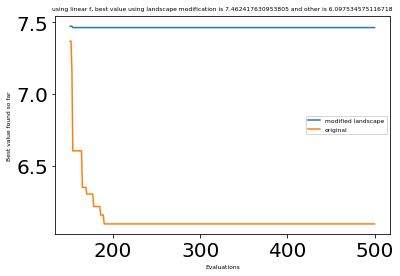

7.462417630953805 6.097534575116718


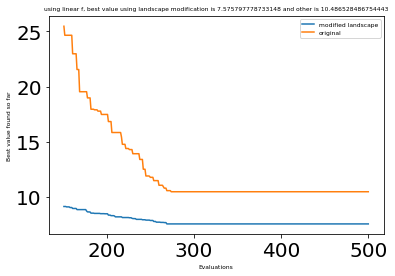

7.575797778733148 10.486528486754443


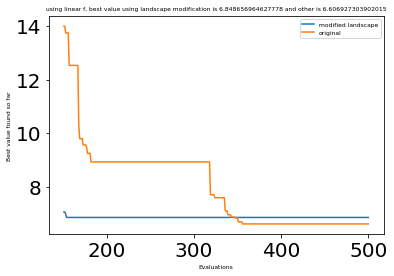

6.848656964627778 6.606927303902015


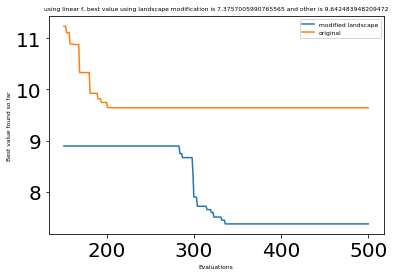

7.3757005990765565 9.642483948209472


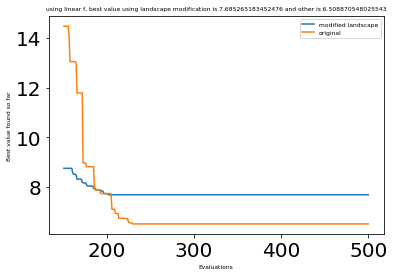

7.685265183452476 6.508870548025543


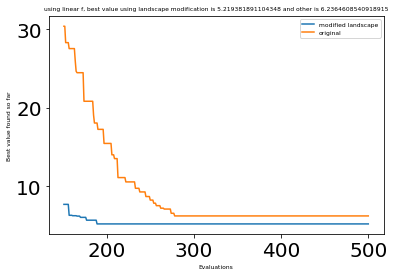

5.219381891104348 6.2364608540918915


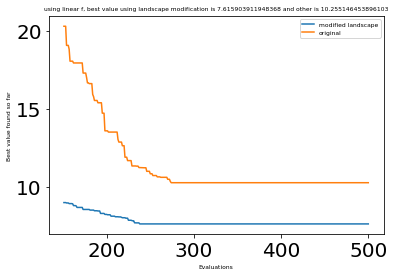

7.615903911948368 10.255146453896103


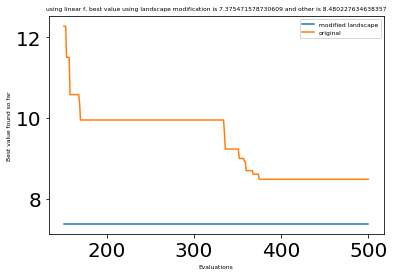

7.375471578730609 8.480227634638357
rosenbrock, square root landscape modification, 0.5 c
landscape modified was better 18 times and was worse 12 times
mean of landscape modified is 7.1860345988921575
mean of non landscape modified is 7.7071810113771315
median of landscape modified is 7.449196500493761
median of non landscape modified is 8.001277834551434
best result of landscape modified is 1.1355170892950959
best of non landscape modified is 2.563130726356541
worst result of landscape modified is 8.741100860982499
worst of non landscape modified is 10.737662178894553


([8.180576215414371,
  7.14298959237409,
  8.038798516047581,
  8.343713890559917,
  7.312183884386505,
  1.1355170892950959,
  6.641662198013676,
  4.535023831951857,
  8.04001565613094,
  7.76534340499887,
  7.435975370033717,
  7.278949487993979,
  8.741100860982499,
  7.285137169331066,
  8.32982794027709,
  6.846278457854709,
  7.792121817245317,
  8.464148027642652,
  7.808970091429022,
  7.33370243835825,
  6.485079003789253,
  7.485327484027131,
  7.462417630953805,
  7.575797778733148,
  6.848656964627778,
  7.3757005990765565,
  7.685265183452476,
  5.219381891104348,
  7.615903911948368,
  7.375471578730609],
 [6.7220307222269495,
  8.522259392899032,
  8.789482808579669,
  10.317146206045692,
  5.617834891826421,
  9.172467805713138,
  5.144274163503074,
  4.403715849393923,
  7.355388818350974,
  7.821303454621602,
  9.68946331660361,
  6.30499451691751,
  2.563130726356541,
  8.20140204012749,
  7.311633582502287,
  7.647827192262131,
  8.91594371295828,
  8.8488392882506

In [195]:
checker(30,path,l2)